# HyTEST D-Score ScoreCard


In [2]:
try:
    import pandas as pd
    import holoviews as hv
    import hvplot.pandas
    import panel as pn
    from geoviews import tile_sources as gvts
except ImportError:
    print("A required library could not be found. ")
    raise

In [3]:
cobalt = pd.read_csv(
    'https://www.sciencebase.gov/catalog/file/get/6181ac65d34e9f2789e44897?f=__disk__22%2F1a%2Fd2%2F221ad2fe9d95de17731ad35d0fc6b417a4b53ee1',
    dtype={'site_no':str, 'huc_cd':str, 'reachcode':str, 'comid':str, 'gagesII_class':str, 'aggecoregion': str}, 
    index_col='site_no'
    )
# Re-format the gage_id/site_no string value.  ex:   "1000000"  ==> "USGS-1000000"
cobalt.rename(index=lambda x: f'USGS-{x}', inplace=True)
cobalt.rename(columns={'dec_lat_va':'Lat', 'dec_long_va':'Lon'} , inplace=True)
print(f"{len(cobalt.index)} gages in this benchmark")
cobalt.head(2)

5390 gages in this benchmark


,Lat,Lon,comid,reachcode,reach_meas,drain_sqkm,huc02,gagesII_class,aggecoregion,complete_yrs,n_days,nldi,swim,gfv1d1,camels
site_no,,,,,,,,,,,,,,,
USGS-01011000,47.069722,-69.079444,721640,01010002000001,53.747189,3186.8,01,Non-ref,NorthEast,33,12146,1,1,1,0
USGS-01013500,47.237500,-68.582778,724696,01010003000003,7.660419,2252.7,01,Ref,NorthEast,33,12146,1,1,1,1


In [4]:
#Data is loaded 
DScore = pd.read_csv(r'./DScore_streamflow_benchmark.csv', dtype={'site_no':str} ).set_index('site_no', drop=False)
# Merge benchmarks with cobalt data to form a single table, indexed by site_no
metrics = DScore.columns.tolist()[1:] 
DScore = DScore.merge(
    cobalt, 
    how='left',
    left_index=True, 
    right_index=True
    )

In [5]:
# Examine the data table
cols = ['site_no']
cols.extend(metrics)
DScore.hvplot.table(
    columns=cols, 
    sortable=True, 
    selectable=True
)

:Table   [site_no,mse,e_bias,e_dist,e_seq,winter,spring,summer,fall,low,below_avg,above_avg,high]

In [6]:
# Map
var_select = pn.widgets.Select(name='Metric', options=metrics, value='mse')
base_map_select = pn.widgets.Select(name='Basemap:', 
                                    options=list(gvts.tile_sources.keys()), 
                                    value='OSM')

@pn.depends(var=var_select, base_map=base_map_select)
def plot(var, base_map):
    return DScore.hvplot.points(x='Lon', y='Lat', color=var, cmap='turbo_r', geo=True, tiles=base_map)

col = pn.Column(var_select, base_map_select, plot)
col.servable('Hydro Assessment Tool')

Column
    [0] Select(name='Metric', options=['mse', 'e_bias', ...], value='mse')
    [1] Select(name='Basemap:', options=['CartoDark', ...], value='OSM')
    [2] ParamFunction(function)

In [7]:
# Box Plots
var_select = pn.widgets.Select(name='Metric', 
        options=metrics, 
        value='mse')

group_select = pn.widgets.Select(name='Group By:', 
        options=['huc02', 'gagesII_class', 'aggecoregion'], 
        value='aggecoregion')

@pn.depends(var_select, group_select)
def plot(var, group):
    return DScore.hvplot.box(y = var, by = group, height=400, width=800, legend=False)

col = pn.Column(var_select, group_select, plot)
col.servable('DScore Benchmark Box Plots')

c:\Users\gtrantham\.conda\envs\hytest\lib\site-packages\holoviews\core\data\pandas.py:221: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  data = [(k, group_type(v, **group_kwargs)) for k, v in
c:\Users\gtrantham\.conda\envs\hytest\lib\site-packages\holoviews\core\data\pandas.py:221: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  data = [(k, group_type(v, **group_kwargs)) for k, v in


Column
    [0] Select(name='Metric', options=['mse', 'e_bias', ...], value='mse')
    [1] Select(name='Group By:', options=['huc02', 'gagesII_class',...], value='aggecoregion')
    [2] ParamFunction(function)

In [8]:
# Histograms
var_select = pn.widgets.Select(name='Metric', 
        options=metrics, 
        value='mse'
    )

group_select = pn.widgets.Select(name='Group By:', 
        options=['huc02', 'gagesII_class', 'aggecoregion'], 
        value='aggecoregion'
    )

@pn.depends(var_select, group_select)
def plot(var, group):
    return DScore.hvplot.hist(var, group, subplots=True, width=400, bins = 500, legend='top')

col = pn.Column(var_select, group_select, plot)
col.servable('DScore Benchmark Histograms')

c:\Users\gtrantham\.conda\envs\hytest\lib\site-packages\holoviews\core\data\pandas.py:221: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  data = [(k, group_type(v, **group_kwargs)) for k, v in


Column
    [0] Select(name='Metric', options=['mse', 'e_bias', ...], value='mse')
    [1] Select(name='Group By:', options=['huc02', 'gagesII_class',...], value='aggecoregion')
    [2] ParamFunction(function)

In [9]:
# metric v lat/lon scatter plot
var_select = pn.widgets.Select(name='Metric', options=metrics, 
                               value='mse')

group_select = pn.widgets.Select(name='Group By:', 
                                    options=['Lon', 'Lat'], 
                                    value='Lon')

@pn.depends(var_select, group_select)
def plot(var, group):
    return DScore.hvplot.scatter(x=group, y=var, height=400, width = 500, legend='top', hover_cols=["site_no","Lat","Lon"])

col = pn.Column(var_select, group_select, plot)
col.servable('Lat/Lon Scatter Plot')

Column
    [0] Select(name='Metric', options=['mse', 'e_bias', ...], value='mse')
    [1] Select(name='Group By:', options=['Lon', 'Lat'], value='Lon')
    [2] ParamFunction(function)

In [10]:
# metric vs metric
var_select = pn.widgets.Select(name='Metric', options=metrics, 
                               value='mse')

var2_select = pn.widgets.Select(name='Metric:', 
                                    options=metrics, 
                                    value='high')

@pn.depends(var_select, var2_select)

def plot(var, var2):
    return DScore.hvplot.scatter(x = var, y = var2, height=400, width = 500, legend='top', hover_cols=['site_no','Lat', 'Lon'])

col = pn.Column(var_select, var2_select, plot)
col.servable('Metric v Metric Scatter Plot')

Column
    [0] Select(name='Metric', options=['mse', 'e_bias', ...], value='mse')
    [1] Select(name='Metric:', options=['mse', 'e_bias', ...], value='high')
    [2] ParamFunction(function)

## Score Card

In [35]:
%run ./D-Score_Suite_v1.ipynb
## defines score() (among other things)

In [32]:
card=pd.DataFrame(data={
    'NWM': DScore[metrics].mean()
    })
card

,NWM
mse,2.142759
e_bias,1.200800
e_dist,0.352309
e_seq,0.589728
winter,0.487134
spring,0.471128
summer,0.589379
fall,0.595122
low,0.889947
below_avg,0.543379


In [34]:
global_variance = 5.698552426981009
normalized_msle = card/global_variance

score_card = (score(normalized_msle, a=3.14) * 100).round().astype(int)
score_card

,NWM
mse,31
e_bias,52
e_dist,82
e_seq,72
winter,76
spring,77
summer,72
fall,72
low,61
below_avg,74


In [29]:
percentage_card = pd.DataFrame(data={
    'NWM' : ((card['NWM'] / DScore.mse.mean()) * 100).round().astype(int)
    })
percentage_card

,NWM
mse,100
e_bias,56
e_dist,16
e_seq,28
winter,23
spring,22
summer,28
fall,28
low,42
below_avg,25


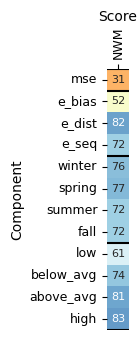

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize = (3.54, 3.5))
ilamb_card(score_card, 
                ax=ax,
                hlines=[0,1,4,8,12])
ax.set_xlabel('Score')
fig.tight_layout()

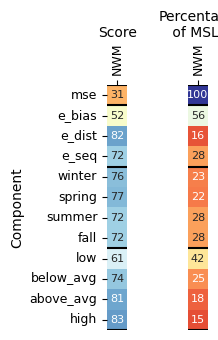

In [38]:

fig = multi_panel_card(score_cards = [score_card, percentage_card],
                            score_labels = ['Score', 'Percentage\n of MSLE'],
                            hlines=[0,1,4,8,12],
                            figsize=(3.54,3.5))
fig.tight_layout()